In [226]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Data manipulation and handling libraries
import pandas as pd
import numpy as np

# Data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sci

# Data preprocessing and EDA libraries
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler

# Model Selection Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# ML Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import xgboost 
from xgboost import XGBRegressor

# Model Evaluation
from sklearn.metrics import r2_score, mean_squared_error

# Warning filter library
import warnings
warnings.filterwarnings('ignore')

# Multicollinearity test
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

In [4]:
df = pd.read_csv('Capstone Project.xlsx')

In [5]:
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


### observation from df.info():
     1) There are no null values
     2) We have 1030 rows and 9 columns
     3) Dependant variable = strength
     4) Rest of all columns are independent variable

In [7]:
df.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


### Analysis from descriptive statistics:
    1) There may be skewness in the data in all columns
    2) There may be chance of outliers if we compare quartile of some columns
    3) Since minimum and q1 are same for slag and ash , so we do not have outliers in the lower whiskers region.
    4) The range value 'age' is from 1 to 365 , we can say that the values are in 'Days'.

In [8]:
def custom_summary(my_df):
    result = []
    for col in my_df.columns:
        if my_df[col].dtypes != 'object':
            stats = OrderedDict({
                'feature_name': col,
                'count' : my_df[col].count(),
                'quartile1': my_df[col].quantile(.25),
                'quartile2': my_df[col].quantile(.50),
                'quartile3': my_df[col].quantile(.75),
                'mean': my_df[col].mean(),
                'max': my_df[col].max(),
                'variance': round(my_df[col].var()),
                'standard deviation': my_df[col].std(),
                'skewness' : my_df[col].skew(),
                'kurtosis' : my_df[col].kurt()
            })
        result.append(stats)
    result_df = pd.DataFrame(result)
    #return result_df

    #skewness type :
    skewness_label = []
    for i in result_df['skewness']:
        if i <= -1:
            skewness_label.append('Highly negatively skewed')
        elif -1 < i <= -0.5:
            skewness_label.append('Moderately negatively skewed')
        elif -0.5 < i <= 0:
            skewness_label.append('Fairly negatively skewed')
        elif 0 < i <= 1:
            skewness_label.append('Fairly positively skewed') 
        elif 0.5 < i <= 1:
            skewness_label.append('Moderately positively skewed') 
        elif i >= 1:
            skewness_label.append('Highly positively skewed') 
    result_df['skewness_comment'] = skewness_label
    
    #kurtosis type :
    kurtosis_label = []
    for i in result_df['kurtosis']:
        if i >= 1:
            kurtosis_label.append('Leptokurtic curve')
        elif i <= -1:
            kurtosis_label.append('Platykuric curve')
        else:
            kurtosis_label.append('Mesokuric curve')
    result_df['kurtosis_comment'] = kurtosis_label
    
    #outliers :
    outliers_label = []
    for col in my_df.columns:
        if my_df[col].dtypes != 'object':
            q1 = my_df[col].quantile(0.25)
            q2 = my_df[col].quantile(0.50)
            q3 = my_df[col].quantile(0.75)
            iqr = q3 - q1
            lower_whisker = q1 - 1.5*iqr
            upper_whisker = q3 + 1.5*iqr
            if len(my_df[(my_df[col] < lower_whisker) | (my_df[col] < upper_whisker)]) > 0:
                outliers_label.append('Have outliers')
            else:
                outliers_label.append('Do not have outliers')
    result_df["outliers_comment"] = outliers_label
    return result_df

In [9]:
custom_summary(df)

,feature_name,count,quartile1,quartile2,quartile3,mean,max,variance,standard deviation,skewness,kurtosis,skewness_comment,kurtosis_comment,outliers_comment
0,cement,1030,192.375,272.900,350.000,281.167864,540.0,10922,104.506364,0.509481,-0.520652,Fairly positively skewed,Mesokuric curve,Have outliers
1,slag,1030,0.000,22.000,142.950,73.895825,359.4,7444,86.279342,0.800717,-0.508175,Fairly positively skewed,Mesokuric curve,Have outliers
2,ash,1030,0.000,0.000,118.300,54.188350,200.1,4096,63.997004,0.537354,-1.328746,Fairly positively skewed,Platykuric curve,Have outliers
3,water,1030,164.900,185.000,192.000,181.567282,247.0,456,21.354219,0.074628,0.122082,Fairly positively skewed,Mesokuric curve,Have outliers
4,superplastic,1030,0.000,6.400,10.200,6.204660,32.2,36,5.973841,0.907203,1.411269,Fairly positively skewed,Leptokurtic curve,Have outliers
5,coarseagg,1030,932.000,968.000,1029.400,972.918932,1145.0,6046,77.753954,-0.040220,-0.599016,Fairly negatively skewed,Mesokuric curve,Have outliers
6,fineagg,1030,730.950,779.500,824.000,773.580485,992.6,6428,80.175980,-0.253010,-0.102177,Fairly negatively skewed,Mesokuric curve,Have outliers
7,age,1030,7.000,28.000,56.000,45.662136,365.0,3990,63.169912,3.269177,12.168989,Highly positively skewed,Leptokurtic curve,Have outliers
8,strength,1030,23.710,34.445,46.135,35.817961,82.6,279,16.705742,0.416977,-0.313725,Fairly positively skewed,Mesokuric curve,Have outliers


### Performing Outlier Treatment

In [10]:
def replace_outlier(my_df, col, method = 'quartile', strategy = 'median'):
    col_data = my_df[col]
    
    if method == 'quartile':
        q1 = my_df[col].quantile(0.25)
        q2 = my_df[col].quantile(0.50)
        q3 = my_df[col].quantile(0.75)
        iqr = q3 - q1
        lower_whisker = q1 - 1.5*iqr
        upper_whisker = q3 + 1.5*iqr
    elif method == 'standard deviation':
        mean = col_data.mean()
        std = col_data.std()
        lower_whisker = mean - 2*std
        upper_whisker = mean + 2*std
    else:
        print('Pass a correct method')
        
    # Printing all the outliers
    outliers = my_df.loc[(col_data < lower_whisker) | (col_data > upper_whisker)]
    outliers_density = round(len(outliers)/len(my_df),2)*100
    if len(outliers) == 0:
        print(f"Feature {col} does not have outliers")
        print('\n')
    else:
        print(f'Feature {col} have outliers')
        print('\n')
        print(f'Total no. of outliers in {col} are {len(outliers)}')
        print(f'Outliers percentage is {outliers_density}%')
        print('\n')
        display(my_df[(col_data < lower_whisker) | (col_data > upper_whisker)])
        
   # Replacing outliers:
    if strategy == 'median':
        my_df.loc[(col_data < lower_whisker) | (col_data > upper_whisker), col] = q2
    elif strategy == 'mean':
        my_df.loc[(col_data < lower_whisker) | (col_data > upper_whisker), col] = mean
    else:
        print('Pass a correct strategy')
        
    return my_df

In [11]:
replace_outlier(df, "slag")

Feature slag have outliers


Total no. of outliers in slag are 2
Outliers percentage is 0.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
918,239.6,359.4,0.0,185.7,0.0,941.6,664.3,28,39.44
990,239.6,359.4,0.0,185.7,0.0,941.6,664.3,7,25.42


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29
...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.30
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,270,55.06


In [12]:
replace_outlier(df, "age")

Feature age have outliers


Total no. of outliers in age are 59
Outliers percentage is 6.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
51,331.0,0.0,0.0,192.0,0.0,978.0,825.0,180,39.00
64,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
93,427.5,47.5,0.0,228.0,0.0,932.0,594.0,180,41.84
99,237.5,237.5,0.0,228.0,0.0,932.0,594.0,180,36.25
103,380.0,0.0,0.0,228.0,0.0,932.0,670.0,180,53.10
133,236.0,0.0,0.0,193.0,0.0,968.0,885.0,365,25.08
144,302.0,0.0,0.0,203.0,0.0,974.0,817.0,180,26.74
149,380.0,95.0,0.0,228.0,0.0,932.0,594.0,270,41.15
152,322.0,0.0,0.0,203.0,0.0,974.0,800.0,180,29.59
157,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29
...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.30
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,28,55.06


In [13]:
replace_outlier(df, "cement")

Feature cement does not have outliers




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29
...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.30
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,28,55.06


In [14]:
replace_outlier(df, "ash")

Feature ash does not have outliers




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29
...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.30
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,28,55.06


In [15]:
replace_outlier(df, "water")

Feature water have outliers


Total no. of outliers in water are 9
Outliers percentage is 1.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
66,237.0,92.0,71.0,247.0,6.0,853.0,695.0,28,28.63
263,236.9,91.7,71.5,246.9,6.0,852.9,695.4,28,28.63
432,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,28,24.24
462,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,100,39.23
587,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,3,7.75
740,140.0,164.0,128.0,237.0,6.0,869.0,656.0,28,35.23
789,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,56,32.85
826,139.7,163.9,127.7,236.7,5.8,868.6,655.6,28,35.23
914,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,14,17.82


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29
...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.30
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,28,55.06


In [16]:
replace_outlier(df, "superplastic")

Feature superplastic have outliers


Total no. of outliers in superplastic are 10
Outliers percentage is 1.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
44,531.3,0.0,0.0,141.8,28.2,852.1,893.7,91,59.2
156,531.3,0.0,0.0,141.8,28.2,852.1,893.7,28,56.4
232,469.0,117.2,0.0,137.8,32.2,852.1,840.5,56,69.3
292,469.0,117.2,0.0,137.8,32.2,852.1,840.5,91,70.7
538,531.3,0.0,0.0,141.8,28.2,852.1,893.7,7,46.9
744,469.0,117.2,0.0,137.8,32.2,852.1,840.5,7,54.9
816,469.0,117.2,0.0,137.8,32.2,852.1,840.5,28,66.9
838,531.3,0.0,0.0,141.8,28.2,852.1,893.7,56,58.8
955,469.0,117.2,0.0,137.8,32.2,852.1,840.5,3,40.2
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.3


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29
...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29
1026,531.3,0.0,0.0,141.8,6.4,852.1,893.7,3,41.30
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,28,55.06


In [17]:
replace_outlier(df, "coarseagg")

Feature coarseagg does not have outliers




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29
...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29
1026,531.3,0.0,0.0,141.8,6.4,852.1,893.7,3,41.30
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,28,55.06


In [18]:
replace_outlier(df, "fineagg")

Feature fineagg have outliers


Total no. of outliers in fineagg are 5
Outliers percentage is 0.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
129,375.0,93.8,0.0,126.6,23.4,852.1,992.6,91,62.5
447,375.0,93.8,0.0,126.6,23.4,852.1,992.6,7,45.7
504,375.0,93.8,0.0,126.6,23.4,852.1,992.6,3,29.0
584,375.0,93.8,0.0,126.6,23.4,852.1,992.6,56,60.2
857,375.0,93.8,0.0,126.6,23.4,852.1,992.6,28,56.7


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29
...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29
1026,531.3,0.0,0.0,141.8,6.4,852.1,893.7,3,41.30
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,28,55.06


In [19]:
replace_outlier(df, "strength")

Feature strength have outliers


Total no. of outliers in strength are 4
Outliers percentage is 0.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
192,315.0,137.0,0.0,145.0,5.9,1130.0,745.0,28,81.75
732,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
950,389.9,189.0,0.0,145.9,22.0,944.7,755.8,91,82.60
1003,323.7,282.8,0.0,183.8,10.3,942.7,659.9,56,80.20


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29
...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29
1026,531.3,0.0,0.0,141.8,6.4,852.1,893.7,3,41.30
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,28,55.06


## ODT(Outliers Detection Technique) Plots
    1) Descriptive Plots
    2) Histogram with outliers
    3) Histogram without outliers

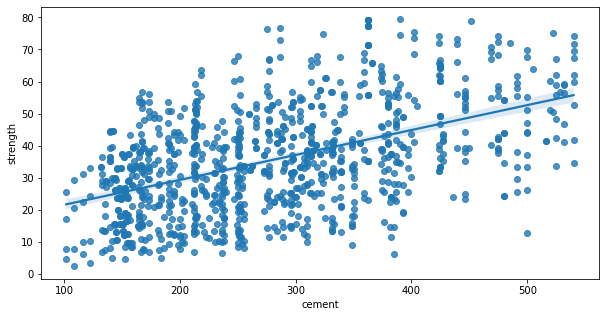

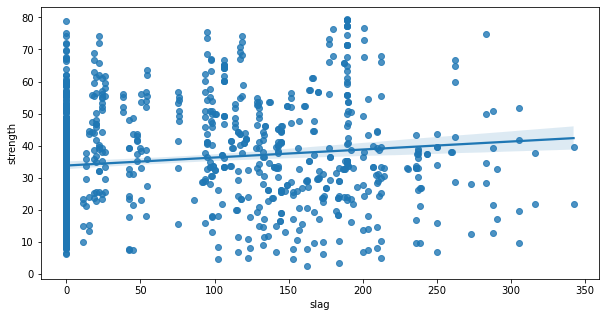

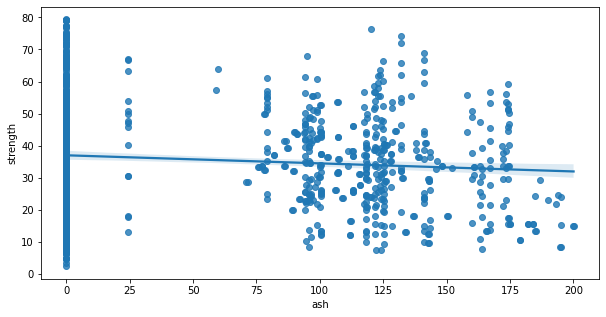

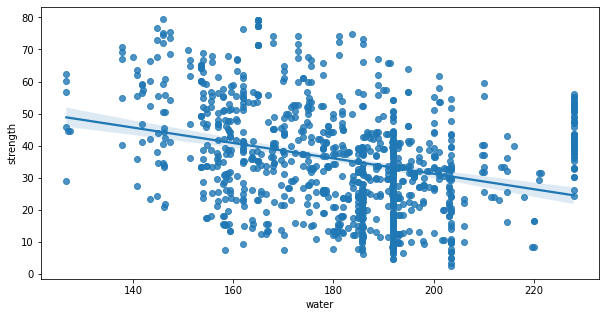

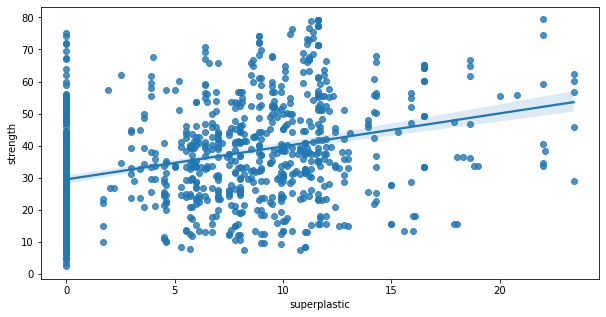

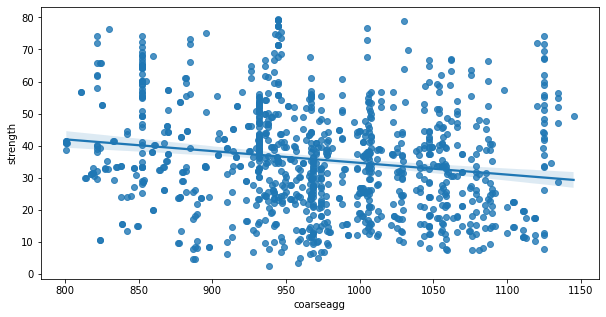

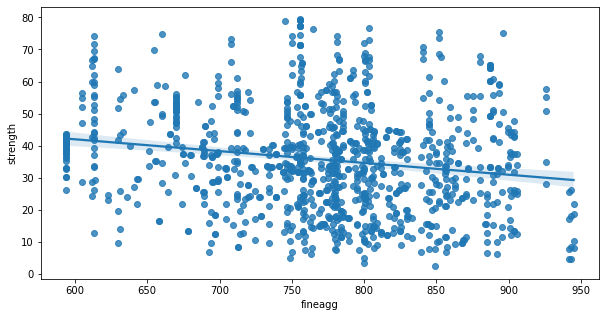

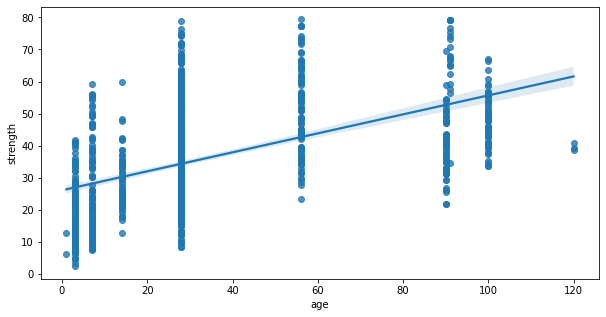

In [20]:
for col in df.columns:
    if col != 'strength':
        fig,ax1 = plt.subplots(figsize = (10,5))
        sns.regplot(x = df[col], y = df['strength'], ax =  ax1)
    

### Analysis
    1) strenth and cement are highly positively correlated
    2) strenth and slag are sightly negatively correlated
    3) strenth and ash are sightly negatively correlated
    4) strenth and water are highly negatively correlated
    5) strenth and superplastic are highly positively correlated
    6) strenth and coarseagg are highly negatively correlated
    7) strenth and fineagg are highly negatively correlated
    8) strenth and age are highly positively correlated

## Multicollinearity test
    Correlation matrix / Hear map


<AxesSubplot:>

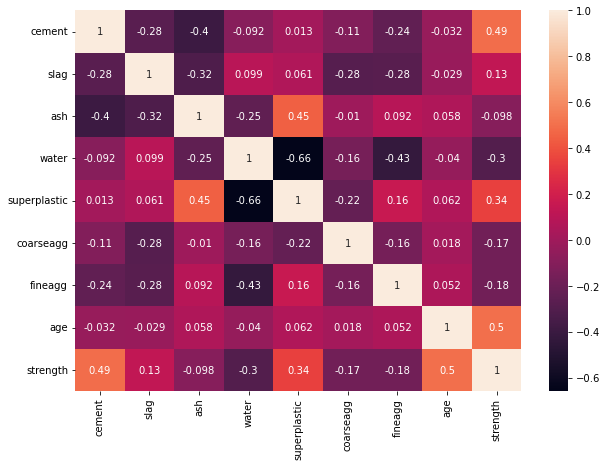

In [21]:
corr = df.corr()
plt.figure(figsize = (10,7))
sns.heatmap(corr, annot = True)


## Multicollinearity test
    VIF(Variance Inflation factor)

In [22]:
def correlation_with_target(data, t_col):
    independent_variable = data.drop(t_col, axis = 1).columns
    corr_result = []
    for col in independent_variable:
        corr_result.append(data[t_col].corr(data[col]))
        print(data[t_col].corr(data[col]))
        #print("corr_result", corr_result)
    result = pd.DataFrame([independent_variable, corr_result], index=['Independent Variables', 'Correlation']).T
    return result

In [23]:
correlation_with_target(df, 'strength')

0.4935179499403563
0.12956088909749622
-0.09797250926018017
-0.3000433754968065
0.34263259121473255
-0.17323378916234916
-0.1761134999275929
0.49971143599864437


,Independent Variables,Correlation
0,cement,0.493518
1,slag,0.129561
2,ash,-0.097973
3,water,-0.300043
4,superplastic,0.342633
5,coarseagg,-0.173234
6,fineagg,-0.176113
7,age,0.499711


## Analysis
    1) Age and cement have 49% correlation with strength
    2) superplastic and water has 34% and 30% with strength

### Applying PCA to treat Multicollinearity

In [24]:
def custom_PCA(X):
    n_comp = len(X.columns)
    #Applying standardscaler for feature scaling
    sc = StandardScaler()
    X = sc.fit_transform(X)
    
    for i in range(1, n_comp):
        pca = PCA(n_components = i)
        p_comp = pca.fit_transform(X)
        evr = np.cumsum(pca.explained_variance_ratio_)
        if evr[i-1] > 0.9: #Means 90% of the information
            pcs = i
            break
    print('Explained Variance Ratio after PCA is: ', evr)
    #creating dataframes of principle components
    
    col = []
    for j in range(1, pcs+1):
        col.append('PC_'+ str(j))
    pca_df = pd.DataFrame(p_comp, columns = col)
    return pca_df
    

In [25]:
pca_df = custom_PCA(df.drop('strength', axis = 1))

Explained Variance Ratio after PCA is:  [0.27112429 0.44666571 0.60914114 0.73584634 0.85926016 0.97264602]


### Joining PCA Features with Target Features

In [26]:
pca_df = pca_df.join(df["strength"], how = 'left') #left join using

In [27]:
pca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PC_1      1030 non-null   float64
 1   PC_2      1030 non-null   float64
 2   PC_3      1030 non-null   float64
 3   PC_4      1030 non-null   float64
 4   PC_5      1030 non-null   float64
 5   PC_6      1030 non-null   float64
 6   strength  1030 non-null   float64
dtypes: float64(7)
memory usage: 56.5 KB


In [28]:
pca_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,strength
0,1.810919,1.331664,-1.284484,-0.306148,-0.067652,-0.886110,29.89
1,-1.823833,-0.573436,-1.058973,0.893130,-0.913984,-0.751061,23.51
2,-0.739819,-0.463200,-0.541643,-1.033210,-0.308068,0.611045,29.22
3,2.766368,0.602978,-0.512532,0.008806,0.086415,0.850548,45.85
4,0.892523,0.966627,-0.863624,1.148561,-0.064439,-1.221228,18.29


In [29]:
pca_df

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,strength
0,1.810919,1.331664,-1.284484,-0.306148,-0.067652,-0.886110,29.89
1,-1.823833,-0.573436,-1.058973,0.893130,-0.913984,-0.751061,23.51
2,-0.739819,-0.463200,-0.541643,-1.033210,-0.308068,0.611045,29.22
3,2.766368,0.602978,-0.512532,0.008806,0.086415,0.850548,45.85
4,0.892523,0.966627,-0.863624,1.148561,-0.064439,-1.221228,18.29
...,...,...,...,...,...,...,...
1025,-1.743036,0.071059,-1.492203,0.045227,-0.449481,0.968953,13.29
1026,-1.079147,-0.572265,3.269799,-1.669125,-0.962953,0.002303,41.30
1027,-0.494143,1.276989,0.318398,-0.053272,-0.153787,0.751019,44.28
1028,2.688411,-0.236744,0.056551,-0.088955,0.105206,1.368321,55.06


# MODEL BUILDING
    1) Custom train test split
    2) Cross-Validation
    3) Hyper - parameter tunning

In [30]:
def train_and_test_split(data, tcol, testsize=0.3, randomstate=100): #tcol is target colum
    X = data.drop(tcol, axis=1)
    y = data[tcol]
    return train_test_split(X, y, test_size = testsize, random_state=randomstate)

In [31]:
def model_builder(model_name, model, data, t_col):
    X_train, X_test, y_train, y_test = train_and_test_split(data,t_col)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    result = [model_name, rmse, r2]
    
    return result


In [32]:
model_builder(model_name = 'LinearRegression', model = LinearRegression(), data = pca_df, t_col = 'strength') 
# pca_df is used as eliminated components
# output = model, rmse, r2 score

['LinearRegression', 9.510886873673915, 0.6519519960039928]

In [33]:
def multiple_models(data, t_col):
    col_names = ['Model Name', 'RMSE', 'R2 Score']
    result = pd.DataFrame(columns = col_names)
    result.loc[len(result)] = model_builder('LinearRegression', LinearRegression(), data, t_col)
    result.loc[len(result)] = model_builder('LassoRegression', Lasso(), data, t_col)
    result.loc[len(result)] = model_builder('RidgeRegression', Ridge(), data, t_col)
    result.loc[len(result)] = model_builder('DecisionTree', DecisionTreeRegressor(), data, t_col)
    result.loc[len(result)] = model_builder('SVR', SVR(), data, t_col)
    result.loc[len(result)] = model_builder('KNN', KNeighborsRegressor(), data, t_col)
    result.loc[len(result)] = model_builder('RandomForest', RandomForestRegressor(), data, t_col)
    result.loc[len(result)] = model_builder('AdaBoost', AdaBoostRegressor(), data, t_col)
    result.loc[len(result)] = model_builder('GradientBoost', GradientBoostingRegressor(), data, t_col)
    result.loc[len(result)] = model_builder('XGBoost', XGBRegressor(), data, t_col)
    
    return result.sort_values('R2 Score', ascending = False)

In [34]:
 multiple_models(pca_df, 'strength')

,Model Name,RMSE,R2 Score
9,XGBoost,6.613111,0.831729
6,RandomForest,6.853610,0.819268
8,GradientBoost,7.071133,0.807613
5,KNN,8.045705,0.750928
7,AdaBoost,8.222309,0.739873
4,SVR,9.107654,0.680839
3,DecisionTree,9.175048,0.676098
1,LassoRegression,9.426183,0.658124
2,RidgeRegression,9.508918,0.652096
0,LinearRegression,9.510887,0.651952


## Cross validation

In [35]:
def k_fold_cv(X, y, fold=10):
    score_lr = cross_val_score(LinearRegression(), X, y, cv = fold)
    score_ls = cross_val_score(Lasso(), X, y, cv = fold)
    score_lrd = cross_val_score(Ridge(), X, y, cv = fold)
    score_dt = cross_val_score(DecisionTreeRegressor(), X, y, cv = fold)
    score_svr = cross_val_score(SVR(), X, y, cv = fold)
    score_knn = cross_val_score(KNeighborsRegressor(), X, y, cv = fold)
    score_rf = cross_val_score(RandomForestRegressor(), X, y, cv = fold)
    score_ab = cross_val_score(AdaBoostRegressor(), X, y, cv = fold)
    score_gb = cross_val_score(GradientBoostingRegressor(), X, y, cv = fold)
    score_xgb = cross_val_score(XGBRegressor(), X, y, cv = fold)
    
    model_name = ["LinearRegression", 'LassoRegression', 'RidgeRegression', 'DecisionTree', 'SVR', 'KNN', 
                  'RandomForest', 'AdaBoost', 'GradientBoost', 'XGBoost']
    scores = [score_lr, score_ls, score_lrd, score_dt, score_svr, score_knn, score_rf, score_ab,
            score_gb, score_xgb]
    result = []
    
    for i in range(len(model_name)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        m_name = model_name[i]
        tmp = [m_name, score_mean, score_std]
        result.append(tmp)
        
    k_fold_df = pd.DataFrame(result, columns = ["Model_Name", "CV_Accuracy", "CV_StandardDeviation"])
    return k_fold_df.sort_values('CV_Accuracy', ascending = False)
        

In [36]:
k_fold_cv(pca_df.drop('strength', axis = 1), pca_df["strength"])

,Model_Name,CV_Accuracy,CV_StandardDeviation
9,XGBoost,0.873262,0.036061
6,RandomForest,0.866163,0.032738
8,GradientBoost,0.829059,0.050316
3,DecisionTree,0.769035,0.065434
5,KNN,0.767726,0.055563
7,AdaBoost,0.729023,0.037837
4,SVR,0.703117,0.042765
2,RidgeRegression,0.663935,0.059437
0,LinearRegression,0.663928,0.059476
1,LassoRegression,0.649837,0.049887


## Hyperparameter Tunning

In [55]:
def tunning(X, y, fold=10):
    param_LASSO = {'alpha' : [1e-15, 1e-13, 1e-11, 1e-9, 1e-7, 1e-5, 1e-3, 1e-1, 0, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500]}
    param_KNN = {'n_neighbors' : [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70]}
    param_DTR = {'max_depth' : [3,5,7,9,10,12,14,16], 'max_features' : ['auto', 'sqrt', 'log2', 2, 3, 4, 5, 6]}
    param_ADB = {'learning_rate' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.8, 0.9, 1]}
    param_SVR = {'gamma' : ['scale', 'auto'], 'C' : [0.5, 1]}
    param_GB = {'alpha' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.8, 0.9, 1]}
    param_XGB = {'eta' : [0.1, 0.2, 0.3, 0.4, 0.5], 'max_depth' : [3,5,7,9,10,12,14,16], 'gamma' : [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500], 'reg_lambda': [0,1]}
    param_RF = {'max_depth' : [3,5,7,9,10,12,14,16], 'max_features' : ['auto', 'sqrt', 'log2', 2, 3, 4, 5, 6]}
    
# Hyperparameter Tunning :

    tune_LASSO = GridSearchCV(Lasso(), param_LASSO, cv = fold)
    tune_RIDGE = GridSearchCV(Ridge(), param_LASSO, cv= fold)
    tune_KNN = GridSearchCV(KNeighborsRegressor(), param_KNN, cv = fold)
    tune_DTR = GridSearchCV(DecisionTreeRegressor(), param_DTR, cv = fold)
    tune_ADB = GridSearchCV(AdaBoostRegressor(), param_ADB, cv = fold)
    tune_SVR = GridSearchCV(SVR(), param_SVR, cv = fold)
    tune_GB = GridSearchCV(GradientBoostingRegressor(), param_GB, cv = fold)
    tune_XGB = GridSearchCV(XGBRegressor(), param_XGB, cv = fold)
    tune_RF = GridSearchCV(RandomForestRegressor(), param_RF, cv = fold)
    
# Fittng X and y variables :
    tune_LASSO.fit(X, y)
    tune_RIDGE.fit(X, y)
    tune_KNN.fit(X, y)
    tune_DTR.fit(X, y)
    tune_ADB.fit(X, y)
    tune_SVR.fit(X, y)
    tune_GB.fit(X, y)
    tune_XGB.fit(X, y)
    tune_RF.fit(X, y)
    
    tune = [tune_LASSO, tune_RIDGE, tune_KNN, tune_DTR, tune_ADB, tune_SVR, tune_GB, tune_XGB, tune_RF]
    models = ['LassoRegression', 'RidgeRegression', 'KNN', 'DecisionTree','AdaBoost', 'SVR',  
                   'GradientBoost', 'XGBoost' , 'RandomForest']
    
    for i in range(len(tune)):
        print('Models', models)
        print('Best Parameters :', tune[i].best_params_ )

In [56]:
tunning(pca_df.drop('strength', axis = 1), pca_df["strength"])

Models ['LassoRegression', 'RidgeRegression', 'KNN', 'DecisionTree', 'AdaBoost', 'SVR', 'GradientBoost', 'XGBoost', 'RandomForest']
Best Parameters : {'alpha': 0.1}
Models ['LassoRegression', 'RidgeRegression', 'KNN', 'DecisionTree', 'AdaBoost', 'SVR', 'GradientBoost', 'XGBoost', 'RandomForest']
Best Parameters : {'alpha': 6}
Models ['LassoRegression', 'RidgeRegression', 'KNN', 'DecisionTree', 'AdaBoost', 'SVR', 'GradientBoost', 'XGBoost', 'RandomForest']
Best Parameters : {'n_neighbors': 4}
Models ['LassoRegression', 'RidgeRegression', 'KNN', 'DecisionTree', 'AdaBoost', 'SVR', 'GradientBoost', 'XGBoost', 'RandomForest']
Best Parameters : {'max_depth': 14, 'max_features': 4}
Models ['LassoRegression', 'RidgeRegression', 'KNN', 'DecisionTree', 'AdaBoost', 'SVR', 'GradientBoost', 'XGBoost', 'RandomForest']
Best Parameters : {'learning_rate': 0.9}
Models ['LassoRegression', 'RidgeRegression', 'KNN', 'DecisionTree', 'AdaBoost', 'SVR', 'GradientBoost', 'XGBoost', 'RandomForest']
Best Parame

## Cross Validation

In [47]:
def cv_post_hpt(X, y , fold=10):
    score_lr = cross_val_score(LinearRegression(), X, y, cv = fold)
    score_ls = cross_val_score(Lasso(), X, y, cv = fold)
    score_lrd = cross_val_score(Ridge(), X, y, cv = fold)
    score_dt = cross_val_score(DecisionTreeRegressor(), X, y, cv = fold)
    score_svr = cross_val_score(SVR(), X, y, cv = fold)
    score_knn = cross_val_score(KNeighborsRegressor(), X, y, cv = fold)
    score_rf = cross_val_score(RandomForestRegressor(), X, y, cv = fold)
    score_ab = cross_val_score(AdaBoostRegressor(), X, y, cv = fold)
    score_gb = cross_val_score(GradientBoostingRegressor(), X, y, cv = fold)
    score_xgb = cross_val_score(XGBRegressor(), X, y, cv = fold)
    
    
    model_name =  ['LinearRegression', 'LassoRegression', 'RidgeRegression', 'KNN', 'DecisionTree','AdaBoost', 'SVR',  
                   'GradientBoost', 'XGBoost' , 'RandomForest']
    
    score = [score_lr, score_ls, score_lrd, score_dt, score_svr, score_knn, score_rf, score_ab,
            score_gb, score_xgb]
    
    result = []
    
    for i in range(len(model_name)):
        score_mean = np.mean(score[i])
        score_std = np.std(score[i])
        m_name = model_name[i]
        temp = [m_name, score_mean, score_std]
        result.append(temp)
    k_fold_df = pd.DataFrame(result, columns=['Model_name', 'CV-Accuracy', 'CV_STD'])
    return k_fold_df.sort_values('CV-Accuracy', ascending = False)
        

In [48]:
cv_post_hpt(pca_df.drop('strength', axis = 1), pca_df["strength"])

,Model_name,CV-Accuracy,CV_STD
9,RandomForest,0.873262,0.036061
6,SVR,0.867423,0.034101
8,XGBoost,0.828806,0.050305
3,KNN,0.771035,0.064306
5,AdaBoost,0.767726,0.055563
7,GradientBoost,0.729172,0.038537
4,DecisionTree,0.703117,0.042765
2,RidgeRegression,0.663935,0.059437
0,LinearRegression,0.663928,0.059476
1,LassoRegression,0.649837,0.049887
